corpus : 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'U5JV')

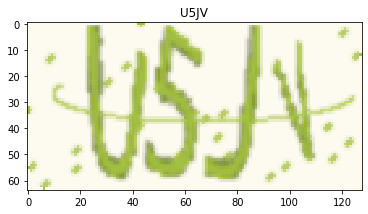

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import string
import captcha
import editdistance

import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
## random generate captcha
## pip install captcha
from captcha.image import ImageCaptcha 



## characters='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
characters = string.digits + string.ascii_uppercase
print("corpus : {}".format(characters))

## set up size of generated image : width == 128, hright == 64, length == 4
width, height, n_len, n_class = 128, 64, 4, len(characters)

## random generate captcha
generator = ImageCaptcha(width=width, height=height)

## random select character from corpus, lenght == n_len
random_str = ''.join([random.choice(characters) for j in range(n_len)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

---

### build corpus

In [2]:
n=1 ## keep zero position for "space" class in CTC loss
character_index = {} ## character to index dictionary
index_character = {} ## index to character dictionary
for character in characters:
    character_index[character] = n
    index_character[n] = character
    n += 1
  

---

### define loader

In [3]:
generator = ImageCaptcha(width=width, height=height)

def loader(batch_size: int = 8, width: int = width, height: int = height, generator: captcha.image.ImageCaptcha = generator):
    """ generator : generate batch of captcha
    Args:
        batch_size: batch_size
        width: width of generated images
        height: height of generated images
    Returns:
        Random generated captcha images with corresponding label
    """
    channels = 3 ## RGB
    while True:
        images = np.zeros((batch_size, height, width, channels), dtype=np.uint8)
        labels = []
        for _ in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            img = generator.generate_image(random_str)
            for item in random_str:
                labels.append(character_index.get(item))
            images[_] = img
        yield images, labels

data_loader = loader()
images, labels = next(data_loader)

---

### layers

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dropout_rate):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p= dropout_rate)
        )

    def forward(self, x):
        out = self.conv(x)
        return out
    
class ImageFeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super(ImageFeatureExtractor, self).__init__()
        self.conv1 = resnet_model.conv1
        self.bn1 = resnet_model.bn1
        self.relu = resnet_model.relu
        self.maxpool = resnet_model.maxpool
        self.layer1 = resnet_model.layer1
        self.layer2 = resnet_model.layer2
        self.layer3 = ConvLayer(128, 64, 3, (2, 1), 1, 0.3)
        self.layer4 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
        self.layer5 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
    
class ImageFeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super(ImageFeatureExtractor, self).__init__()
        self.layer1 = ConvLayer(3, 64, 3, (2, 2), 1, 0.3)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.layer2 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.layer3 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
        self.layer4 = ConvLayer(64, 64, 3, (2, 1), 1, 0.3)
    def forward(self, x):
        x = self.layer1(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    
class BiRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,drop=0.3):
        super(BiRNN, self).__init__()
        self.GRU = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=False, dropout=drop, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection

    def forward(self, x):
        out, _ = self.GRU(x)# out: tensor of shape (seq_length, batch_size, hidden_size*2)
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out
    
class CRNN(nn.Module):
    def __init__(self, cnn_backbone, num_classes=37):
        super(CRNN, self).__init__()
        self.feature_extractor = ImageFeatureExtractor(cnn_backbone)
        self.GRU_First = BiRNN(64, 256, 2, 256, 0.3)
        self.GRU_Second = BiRNN(256, 256, 2, 256, 0.3)
        self.output = torch.nn.Linear(256,num_classes) 
        

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.squeeze(2).permute(2,0,1)
        x = self.GRU_First(x)
        x = self.GRU_Second(x)
        x = self.output(x)
        return x

In [5]:
model = ImageFeatureExtractor('')

In [6]:
output = model(torch.randn(8, 3, 64, 128))

In [7]:
output.shape

torch.Size([8, 64, 1, 16])

---

### check instance type

In [8]:
model = CRNN(cnn_backbone=models.resnet34(pretrained=True))

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
model.to(device)
model.train()
print('device : {}'.format(device))

device : cpu


---

In [9]:
images, labels = next(data_loader)
images = torch.tensor(images, dtype=torch.float32)

In [10]:
images, labels = next(data_loader)
images = torch.tensor(images, dtype=torch.float32).to(device)
images = images.permute(0, 3, 1, 2)

output = model(images)

output_step = output.shape[0]
print(output.shape)

torch.Size([16, 8, 37])


---

### set up traininig elements

In [11]:

batch_size = 64
data_loader = loader(batch_size=batch_size)
ctc_loss = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True) 

input_lengths = torch.tensor([output_step for _ in range(batch_size)],dtype=torch.long) ## output timestep
target_lengths = torch.tensor([4 for _ in range(batch_size)],dtype=torch.long) ## it can be dynamic, but in our case is fixed

optimizer = optim.Adam(model.parameters(), lr=0.001 / batch_size)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

model_parameters = filter(lambda p: p.requires_grad, model.train().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('total parameters：' ,params)

writer = SummaryWriter(log_dir='crnn_ctc_writer/')

max_iterations = 10000
early_stop = 20


total parameters： 4034533


---

In [12]:
def decode(prediction, index_character_dictionary=index_character):
    predict_string = ''
    previous_step = 0
    for character in prediction:
        if character > 0:
            if previous_step != character:
                predict_string += index_character_dictionary.get(character)
        previous_step = character
    return predict_string
    
def get_editdistance_loss(y_true: str, y_pred: str) -> int:
    """Edit distance between two string"""
    return editdistance.distance(y_true, y_pred)

def get_similarity_score(y_true: str, y_pred: str) -> int:
    max_len = max(len(y_pred), len(y_true))
    return (max_len - get_editdistance_loss(y_true, y_pred)) / max_len

---

In [ ]:

for iteration in tqdm(range(max_iterations)):
    
    if (iteration != 0) and (iteration % 500 == 0):
        lr_scheduler.step()
    if (iteration % 500 == 0):
        average_score_list = []
        average_loss_list = []
    
    images, labels = next(data_loader)
    images = torch.tensor(images).type(torch.FloatTensor).to(device)
    labels = torch.tensor(labels).type(torch.LongTensor).to(device)
    images = images / 127.5 - 1 
    images = images.permute(0,3,1,2)

    optimizer.zero_grad()

    output = model(images)
    
    prediction = output.detach().clone()
    prediction = F.softmax(prediction, 2)
    prediction = prediction.argmax(2).permute(1, 0)
    prediction = prediction.cpu().numpy()
    

    
    output = torch.nn.functional.log_softmax(output, dim=2)
    loss = ctc_loss(output, labels, input_lengths, target_lengths)
    loss.backward()
    optimizer.step()
    
    loss = loss.detach().item()
    average_loss_list.append(loss)
    
    
    decode_prediction = []
    for item in prediction:
        decode_string = decode(item)
        decode_prediction.append(decode_string)
        
    label_convert = labels.clone().detach().cpu().numpy()
    label_convert = label_convert.reshape(-1, 4)
    decode_label = []
    for item in label_convert:
        decode_string = ''
        for character in item:
            decode_string += index_character.get(character)
        decode_label.append(decode_string)
        
    score_list = []
    
    for predict, ground_truth in zip(decode_prediction, decode_label):
        score = get_similarity_score(ground_truth, predict)
        score_list.append(score)
    
    average_score = np.mean(score_list)
    average_score_list.append(average_score)

    if iteration % 500 == 0:  
        mean_loss_for_100_iteration = np.mean(average_loss_list)
        mean_accuracy_for_100_iteration = np.mean(average_score_list)
        
        writer.add_scalar('train/loss', mean_loss_for_100_iteration, iteration)
        writer.add_scalar('train/score', mean_accuracy_for_100_iteration, iteration)
        
        print('current status : {} iterations'.format(iteration))
        print('current loss： ', mean_loss_for_100_iteration)
        print('accuracy： ', mean_accuracy_for_100_iteration)
        print('\n')



  0%|          | 1/10000 [00:00<2:34:25,  1.08it/s]

current status : 0 iterations
current loss：  11.45068073272705
accuracy：  0.04444444444444444




  0%|          | 26/10000 [00:21<2:19:39,  1.19it/s]